Cross Validation 1

size = 121655

test size 4k+

epoch-3

apply sigmoid (prediction probabilities are logits)

groups-9

target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

threshold-tuning = yes

df_2k = df[(df['Rating'] >= 4.0) & (df['Maximum_Installs'] >= 5000)]

accuracy score : F1 score (micro) and ROC_AUC score

## 1. Setup

In [1]:
!pip install sentencepiece

In [2]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 895 kB 71.2 MB/s 
     |████████████████████████████████| 596 kB 77.1 MB/s 
     |████████████████████████████████| 6.6 MB 82.7 MB/s 
     |████████████████████████████████| 77 kB 8.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


--- reconnect --

In [3]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla P100-PCIE-16GB


## 2. Load Dataset

In [5]:
## uploading csv files on drive (to avoid uploading on colab in every session)

from google.colab import drive
drive.mount("/content/drive/")

## drive path
train_path = "/content/drive/MyDrive/MetadataCSV/data_121655/CV_df_train_1.csv"
val_path = "/content/drive/MyDrive/MetadataCSV/data_121655/CV_df_val_1.csv"
test_path = "/content/drive/MyDrive/MetadataCSV/test_dataset.csv"

Mounted at /content/drive/


In [6]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path) 
df_test = pd.read_csv(test_path)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(97324, 23)
(24331, 23)
(4624, 23)


In [7]:
df_train = df_train.sample(n=85000)
print(df_train.shape)

(85000, 23)


In [8]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Contacts,SMS,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length
23724,Lovely Flower Photo Frame,com.at.love.flower.photo.frame.lovely.floral.p...,Communication,4.2,53083,False,Lovely Flower Photo Frame\r\nCollection of bes...,https://photoframeintira.blogspot.com/2019/05/...,0,1,...,0,0,1,1,0,0,2562,lovely flower photo frame collection of best l...,2537,487
13875,Full Tally Erp9 Course | Full Tally Erp9 Tutorial,com.kunalapps.tallyinenglish,Education,4.3,74587,False,Note : This is not a Tally Solution or Tally.E...,https://docs.google.com/document/d/1ObBRbYqcFQ...,0,0,...,0,0,1,1,0,0,3725,note this is not a tally solution or tally.erp...,3112,530


In [9]:
target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

In [10]:
# getting number of nonzeros in each column
df_train[target_list].astype(bool).sum(axis=0)

Camera        14295
Location      14266
Microphone     7720
Contacts       9139
Storage       42147
Phone         13196
SMS             302
Call_Log        194
Calendar       1597
dtype: int64

In [11]:
df_val[target_list].astype(bool).sum(axis=0)

Camera         4117
Location       4056
Microphone     2234
Contacts       2689
Storage       12040
Phone          3818
SMS              73
Call_Log         50
Calendar        417
dtype: int64

In [12]:
df_test[target_list].astype(bool).sum(axis=0)

Camera         745
Location       716
Microphone     436
Contacts       500
Storage       2402
Phone          652
SMS             11
Call_Log         6
Calendar        90
dtype: int64

## 3. XLNet Tokenizer - Preprocess Data

### 3.1. Tokenize

In [13]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [14]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [15]:
train_text_list = df_train['Clean_Description'].values
val_text_list = df_val['Clean_Description'].values
test_text_list = df_test['Clean_Description'].values

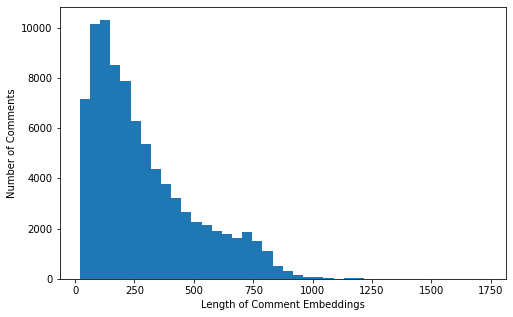

In [16]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

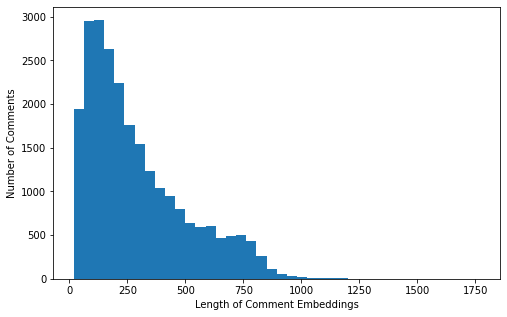

In [17]:
plot_sentence_embeddings_length(val_text_list, tokenizer)

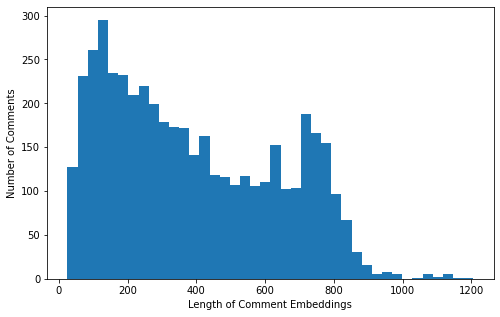

In [18]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [19]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [20]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[ 8109,  7544,  2532, ...,   632,     4,     3],
       [ 2039,    52,    27, ...,  8564,     4,     3],
       [  145,    24,   307, ...,  6066,     4,     3],
       ...,
       [ 1991,    17,  2409, ...,    73,     4,     3],
       [  133,  1804,  1030, ...,    18,     4,     3],
       [  109, 22917,  5523, ...,     0,     0,     0]])

In [21]:
# create input id tokens
val_input_ids = tokenize_inputs(val_text_list, tokenizer, num_embeddings=250)
val_input_ids

array([[ 9028,    23,  9593, ...,     0,     0,     0],
       [ 2332,    21, 10288, ...,     0,     0,     0],
       [  112,  3095,    40, ...,     0,     0,     0],
       ...,
       [  132,    52,   697, ...,     0,     0,     0],
       [   17,   529,   155, ...,  2476,     4,     3],
       [10370,  1942,  2721, ...,     0,     0,     0]])

In [22]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[  108,    44,    41, ...,     0,     0,     0],
       [ 2039,    40,  8425, ...,     0,     0,     0],
       [   17, 12293,  2686, ...,   177,     4,     3],
       ...,
       [26941,   669,    17, ...,   751,     4,     3],
       [ 1184,  2387,  1603, ...,   181,     4,     3],
       [  113,   108,  4626, ...,  1304,     4,     3]])

### 3.2. Attention Masks

In [23]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
#train_attention_masks

In [24]:
# create attention masks
val_attention_masks = create_attn_masks(val_input_ids)
#val_attention_masks

In [25]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
#test_attention_masks

In [26]:
# add input ids and attention masks to the dataframe
df_train["features"] = train_input_ids.tolist()
df_train["masks"] = train_attention_masks

df_val["features"] = val_input_ids.tolist()
df_val["masks"] = val_attention_masks

df_test["features"] = test_input_ids.tolist()
df_test["masks"] = test_attention_masks

In [27]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
23724,Lovely Flower Photo Frame,com.at.love.flower.photo.frame.lovely.floral.p...,Communication,4.2,53083,False,Lovely Flower Photo Frame\r\nCollection of bes...,https://photoframeintira.blogspot.com/2019/05/...,0,1,...,1,1,0,0,2562,lovely flower photo frame collection of best l...,2537,487,"[8109, 7544, 2532, 4240, 1692, 20, 252, 8109, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13875,Full Tally Erp9 Course | Full Tally Erp9 Tutorial,com.kunalapps.tallyinenglish,Education,4.3,74587,False,Note : This is not a Tally Solution or Tally.E...,https://docs.google.com/document/d/1ObBRbYqcFQ...,0,0,...,1,1,0,0,3725,note this is not a tally solution or tally.erp...,3112,530,"[2039, 52, 27, 50, 24, 15623, 1938, 49, 15623,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [28]:
df_val.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,crescendo com Luluca Wallpapers,com.eec.luluca,Personalization,4.5,14000,False,crescendo com Luluca Wallpapers provides image...,https://cansudogan3452.wixsite.com/privacy/giz...,0,0,...,1,0,0,0,763,crescendo com luluca wallpapers provides image...,729,165,"[9028, 23, 9593, 1079, 2748, 17, 2311, 19908, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,My Minnesota WIC App,io.cordova.FoodConnectNavyWhite,Shopping,4.2,85523,False,Supported Android version: 6.0 or above\r\n\r\...,http://www.health.state.mn.us/divs/fh/wic/loca...,0,1,...,1,0,0,0,1147,supported android version . or above my mn app...,1114,222,"[2332, 21, 10288, 1040, 17, 9, 49, 785, 94, 17...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [29]:
df_test.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,0,...,1,0,0,0,901,if you are a poetry lover and did not find the...,876,191,"[108, 44, 41, 24, 7163, 11139, 21, 190, 50, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,0,...,1,0,0,0,302,note from developer force close on froyo . fir...,284,70,"[2039, 40, 8425, 779, 474, 31, 17, 12803, 4333...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [30]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

In [31]:
df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [32]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])

In [33]:
acnet_text_list = df_acnet['Clean_Description'].values

# create input id tokens
acnet_input_ids = tokenize_inputs(acnet_text_list, tokenizer, num_embeddings=250)

# create attention masks
acnet_attention_masks = create_attn_masks(acnet_input_ids)

# add input ids and attention masks to the dataframe
df_acnet["features"] = acnet_input_ids.tolist()
df_acnet["masks"] = acnet_attention_masks

### 3.3. Train, Valid Split

In [ ]:
#X_train = df_train["features"].values.tolist()
#X_valid = df_val["features"].values.tolist()
#
#train_masks = df_train["masks"].values.tolist()
#valid_masks = df_val["masks"].values.tolist()
#
#label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']
#Y_train = df_train[label_cols].values.tolist()
#Y_valid = df_val[label_cols].values.tolist()

In [34]:
X_train = df_train["features"].values.tolist() + df_acnet["features"].values.tolist() + df_test["features"].values.tolist()

train_masks = df_train["masks"].values.tolist() + df_acnet["masks"].values.tolist() + df_test["masks"].values.tolist()

label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']
Y_train = df_train[label_cols].values.tolist() + df_acnet[label_cols].values.tolist() + df_test[label_cols].values.tolist()

In [35]:
X_valid = df_val["features"].values.tolist()

valid_masks = df_val["masks"].values.tolist()

label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']
Y_valid = df_val[label_cols].values.tolist()

### 3.4. Create Dataloaders

In [36]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [37]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [38]:
# Function for class weights

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)

    print(class_series)
    print(class_labels)

    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])
    #print(n_samples)
    #print(n_classes)

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    #return dict(zip(class_labels, class_weights))
    return class_weights

In [39]:
class_series = np.array(Y_train)
class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
print(class_wt)
class_wt = torch.tensor(class_wt)
print(class_wt)

[0.662475167550811, 0.6617384098739587, 1.2181278098908157, 1.0041029713453775, 0.22415754406181213, 0.724490283149501, 19.26730158730159, 34.17342342342342, 5.64786897450214]
tensor([ 0.6625,  0.6617,  1.2181,  1.0041,  0.2242,  0.7245, 19.2673, 34.1734,
         5.6479])


## 4. XLNet Fine Tuning

### 4.1. Train our model

In [40]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      ##
      #mycode-start
      class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
      class_wt = torch.tensor(class_wt)
      class_wt = class_wt.to(device)
      #mycode-end

      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
     
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### 4.2. XLNetForMultiLabelSequenceClassification

In [41]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
      class_wt = torch.tensor(class_wt)
      class_wt = class_wt.to('cuda')
      loss_fct = BCEWithLogitsLoss(pos_weight=class_wt)
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 4.3. Optimizer & Learning Rate Scheduler

In [42]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### 4.4. Training Loop

In [43]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_mod5.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.01515966598786226
Valid loss: 0.01319899969377087


Epoch:  33%|███▎      | 1/3 [5:23:09<10:46:18, 19389.06s/it]

Saving model at epoch 0 with validation loss of 0.01319899969377087


Train loss: 0.012484843556632786
Valid loss: 0.012231553845420816


Epoch:  67%|██████▋   | 2/3 [10:47:02<5:23:35, 19415.29s/it]

Saving model at epoch 1 with validation loss of 0.012231553845420816


Train loss: 0.011054592551396923
Valid loss: 0.011975888091043305


Epoch: 100%|██████████| 3/3 [16:11:29<00:00, 19429.71s/it]

Saving model at epoch 2 with validation loss of 0.011975888091043305




Text(0.5, 1.0, 'Loss vs Number of Epochs')

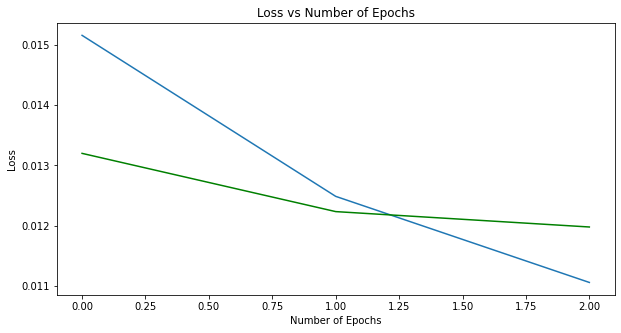

In [44]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## 5. Performance On Test Set

In [45]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [46]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, df_test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[5.76078985e-03, 2.57438105e-02, 6.85235858e-03, ...,
        1.13400783e-04, 3.08930961e-04, 4.48117993e-04],
       [1.24444366e-02, 4.38942853e-03, 4.27113939e-03, ...,
        3.01677010e-05, 8.18071203e-06, 6.47760229e-04],
       [2.72538841e-01, 2.04206645e-01, 4.32935566e-01, ...,
        2.14774031e-02, 1.39728934e-02, 1.75354064e-01],
       ...,
       [3.85383219e-01, 1.19055197e-01, 3.88721704e-01, ...,
        3.36458115e-03, 2.21652468e-03, 4.22979482e-02],
       [2.23258990e-04, 7.71731317e-01, 9.98937547e-01, ...,
        1.53243388e-06, 3.81874408e-08, 2.45190549e-05],
       [6.25441922e-03, 4.42294264e-03, 1.08851213e-02, ...,
        6.00782369e-05, 3.85971871e-05, 1.05209430e-04]])

In [47]:
label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

df_test['P_Camera'] = pred_probs[:,0]
df_test['P_Location'] = pred_probs[:,1]
df_test['P_Microphone'] = pred_probs[:,2]
df_test['P_Contacts'] = pred_probs[:,3]
df_test['P_Storage'] = pred_probs[:,4]
df_test['P_Phone'] = pred_probs[:,5]
df_test['P_SMS'] = pred_probs[:,6]
df_test['P_Call_Log'] = pred_probs[:,7]
df_test['P_Calendar'] = pred_probs[:,8]

In [48]:
df_test.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.005761,0.025744,0.006852,0.008375,0.154830,0.016373,0.000113,0.000309,0.000448
1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.012444,0.004389,0.004271,0.006645,0.024033,0.013144,0.000030,0.000008,0.000648


In [49]:
test_to_csv = df_test.reset_index()
test_to_csv.head(2)

,index,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.005761,0.025744,0.006852,0.008375,0.154830,0.016373,0.000113,0.000309,0.000448
1,1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.012444,0.004389,0.004271,0.006645,0.024033,0.013144,0.000030,0.000008,0.000648


In [50]:
true_l = df_test[['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']]
pred_l = df_test[['P_Camera', 'P_Location', 'P_Microphone', 'P_Contacts', 'P_Storage', 'P_Phone', 'P_SMS', 'P_Call_Log', 'P_Calendar']]


In [51]:
true_labels = true_l.to_numpy()
predictions = pred_l.to_numpy()

In [52]:
np.save("true_labels.npy", true_labels)
np.save("predictions.npy", predictions)

In [53]:
predictions

array([[5.76078985e-03, 2.57438105e-02, 6.85235858e-03, ...,
        1.13400783e-04, 3.08930961e-04, 4.48117993e-04],
       [1.24444366e-02, 4.38942853e-03, 4.27113939e-03, ...,
        3.01677010e-05, 8.18071203e-06, 6.47760229e-04],
       [2.72538841e-01, 2.04206645e-01, 4.32935566e-01, ...,
        2.14774031e-02, 1.39728934e-02, 1.75354064e-01],
       ...,
       [3.85383219e-01, 1.19055197e-01, 3.88721704e-01, ...,
        3.36458115e-03, 2.21652468e-03, 4.22979482e-02],
       [2.23258990e-04, 7.71731317e-01, 9.98937547e-01, ...,
        1.53243388e-06, 3.81874408e-08, 2.45190549e-05],
       [6.25441922e-03, 4.42294264e-03, 1.08851213e-02, ...,
        6.00782369e-05, 3.85971871e-05, 1.05209430e-04]])

In [54]:
true_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 6. Threshold Calculation

In [55]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data simulation
from sklearn.datasets import make_classification     # Create a synthetic dataframe
from sklearn.linear_model import LogisticRegression  # Classification model
from sklearn.model_selection import train_test_split # Split the dataframe
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

In [56]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [57]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("predictions.npy")
  true_labels = np.load("true_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.2979 with F-Score: 0.7385
permission  1
Length of sequence: 10000
Best Threshold: 0.1692 with F-Score: 0.6503
permission  2
Length of sequence: 10000
Best Threshold: 0.353 with F-Score: 0.7243
permission  3
Length of sequence: 10000
Best Threshold: 0.2412 with F-Score: 0.5904
permission  4
Length of sequence: 10000
Best Threshold: 0.0844 with F-Score: 0.8144
permission  5
Length of sequence: 10000
Best Threshold: 0.1893 with F-Score: 0.5971
permission  6
Length of sequence: 10000
Best Threshold: 0.684 with F-Score: 0.6154
permission  7
Length of sequence: 10000
Best Threshold: 0.9398 with F-Score: 0.7692
permission  8
Length of sequence: 10000
Best Threshold: 0.381 with F-Score: 0.617
-------------------------------------
optimal threshold tuning for f-score
[0.2979, 0.1692, 0.353, 0.2412, 0.0844, 0.1893, 0.684, 0.9398, 0.381]


In [58]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("predictions.npy")
  true_labels = np.load("true_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.125 with G-Mean: 0.8822
FPR: 0.1268, TPR: 0.8913
permission  1
Best Threshold: 0.0569 with G-Mean: 0.8182
FPR: 0.1778, TPR: 0.8142
permission  2
Best Threshold: 0.1356 with G-Mean: 0.8968
FPR: 0.1256, TPR: 0.9197
permission  3
Best Threshold: 0.0833 with G-Mean: 0.8438
FPR: 0.1663, TPR: 0.854
permission  4
Best Threshold: 0.1429 with G-Mean: 0.8066
FPR: 0.1809, TPR: 0.7943
permission  5
Best Threshold: 0.0811 with G-Mean: 0.7912
FPR: 0.2314, TPR: 0.8144
permission  6
Best Threshold: 0.101 with G-Mean: 0.9786
FPR: 0.0423, TPR: 1.0
permission  7
Best Threshold: 0.7232 with G-Mean: 0.9984
FPR: 0.0032, TPR: 1.0
permission  8
Best Threshold: 0.1642 with G-Mean: 0.9416
FPR: 0.0613, TPR: 0.9444
-------------------------------------
ROC curve with G-mean threshold tuning
[0.125, 0.0569, 0.1356, 0.0833, 0.1429, 0.0811, 0.101, 0.7232, 0.1642]


## 7. Performance Score

In [ ]:
#Fscore micro for different thresholds-

In [59]:
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [60]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f_at_1(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

   
    acc[0] = f1_score(labels[:, 0], preds_th[:, 0])
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1])
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2])
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3])
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4])
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5])
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6])
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7])
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8])

   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [61]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/F1_CV1_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.7385
  Location  : 0.6503
  Microphone: 0.7243
  Contacts  : 0.5904
  Storage   : 0.8144
  Phone     : 0.5971
  SMS       : 0.6154
  Call_Log  : 0.7692
  Calendar  : 0.6170

  Average F1 score: 0.6796


In [62]:
#Fscore micro for different thresholds-

In [63]:
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [64]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f1micro_accuracy(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

    acc[0] = f1_score(labels[:, 0], preds_th[:, 0], average='micro')
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1], average='micro')
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2], average='micro')
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3], average='micro')
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4], average='micro')
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5], average='micro')
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6], average='micro')
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7], average='micro')
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8], average='micro')
    
   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [65]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/F1Mic_CV1_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.9165
  Location  : 0.8986
  Microphone: 0.9496
  Contacts  : 0.9133
  Storage   : 0.7887
  Phone     : 0.8806
  SMS       : 0.9978
  Call_Log  : 0.9994
  Calendar  : 0.9844

  Average F1 (micro) score: 0.9254


In [ ]:
#roc-auc score for different thresholds-

In [66]:
import numpy as np
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [67]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import roc_auc_score

def roc_auc(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_roc[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_roc[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_roc[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_roc[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_roc[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_roc[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_roc[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_roc[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_roc[8]


    acc[0] = roc_auc_score(labels[:, 0], preds_th[:, 0])
    acc[1] = roc_auc_score(labels[:, 1], preds_th[:, 1])
    acc[2] = roc_auc_score(labels[:, 2], preds_th[:, 2])
    acc[3] = roc_auc_score(labels[:, 3], preds_th[:, 3])
    acc[4] = roc_auc_score(labels[:, 4], preds_th[:, 4])
    acc[5] = roc_auc_score(labels[:, 5], preds_th[:, 5])
    acc[6] = roc_auc_score(labels[:, 6], preds_th[:, 6])
    acc[7] = roc_auc_score(labels[:, 7], preds_th[:, 7])
    acc[8] = roc_auc_score(labels[:, 8], preds_th[:, 8])
   

    #print(acc)
    return acc

In [68]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ROC_CV1_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.8822
  Location  : 0.8182
  Microphone: 0.8971
  Contacts  : 0.8438
  Storage   : 0.8067
  Phone     : 0.7914
  SMS       : 0.9789
  Call_Log  : 0.9984
  Calendar  : 0.9416

  Average ROC_AUC score: 0.8842


# ACNET Performance

#### a) Data Preparation

In [69]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

In [70]:
df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [71]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])

In [72]:
df_acnet.head(2)

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...


In [73]:
acnet_text_list = df_acnet['Clean_Description'].values

# create input id tokens
acnet_input_ids = tokenize_inputs(acnet_text_list, tokenizer, num_embeddings=250)

# create attention masks
acnet_attention_masks = create_attn_masks(acnet_input_ids)

# add input ids and attention masks to the dataframe
df_acnet["features"] = acnet_input_ids.tolist()
df_acnet["masks"] = acnet_attention_masks

In [74]:
df_acnet.head(2)

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description,features,masks
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...,"[5988, 27, 978, 28, 6073, 31769, 3116, 21, 102...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...,"[52, 5523, 12861, 573, 21584, 23, 4473, 18, 10...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


#### b) Get Predictions

In [75]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, df_acnet, num_labels, device="cuda", batch_size=32)
pred_probs

array([[6.26519555e-03, 3.27581204e-02, 5.81895560e-03, ...,
        8.03211064e-04, 4.74032247e-03, 5.87416987e-04],
       [3.26407775e-02, 4.16557007e-02, 6.35577962e-02, ...,
        5.33165514e-01, 5.39987266e-01, 4.18543480e-02],
       [5.92918368e-03, 1.01728598e-02, 1.18006635e-02, ...,
        5.68109062e-05, 2.92605146e-05, 1.21050318e-04],
       ...,
       [1.26209669e-02, 2.38743853e-02, 9.96107236e-03, ...,
        2.31844932e-03, 3.82142747e-03, 7.75840366e-04],
       [8.58888682e-03, 1.14387730e-02, 4.92445715e-02, ...,
        1.28995779e-03, 1.55040119e-02, 8.03479285e-04],
       [3.42910662e-02, 1.09632373e-01, 4.17427793e-02, ...,
        1.83722991e-02, 5.76713309e-02, 7.00726500e-03]])

In [76]:
label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

df_acnet['P_Camera'] = pred_probs[:,0]
df_acnet['P_Location'] = pred_probs[:,1]
df_acnet['P_Microphone'] = pred_probs[:,2]
df_acnet['P_Contacts'] = pred_probs[:,3]
df_acnet['P_Storage'] = pred_probs[:,4]
df_acnet['P_Phone'] = pred_probs[:,5]
df_acnet['P_SMS'] = pred_probs[:,6]
df_acnet['P_Call_Log'] = pred_probs[:,7]
df_acnet['P_Calendar'] = pred_probs[:,8]

In [77]:
acnet_to_csv = df_acnet.reset_index()
acnet_to_csv.head(2)

,index,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.006265,0.032758,0.005819,0.012993,0.029369,0.008296,0.000803,0.004740,0.000587
1,1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.032641,0.041656,0.063558,0.325860,0.203081,0.070551,0.533166,0.539987,0.041854


In [78]:
true_l = df_acnet[['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']]
pred_l = df_acnet[['P_Camera', 'P_Location', 'P_Microphone', 'P_Contacts', 'P_Storage', 'P_Phone', 'P_SMS', 'P_Call_Log', 'P_Calendar']]


In [79]:
true_labels = true_l.to_numpy()
predictions = pred_l.to_numpy()

In [80]:
np.save("acnet_labels.npy", true_labels)
np.save("acnet_predictions.npy", predictions)

#### c) Threshold Calculation

In [81]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [82]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.1219 with F-Score: 0.5898
permission  1
Length of sequence: 10000
Best Threshold: 0.0909 with F-Score: 0.6418
permission  2
Length of sequence: 10000
Best Threshold: 0.1983 with F-Score: 0.7434
permission  3
Length of sequence: 10000
Best Threshold: 0.2813 with F-Score: 0.6703
permission  4
Length of sequence: 10000
Best Threshold: 0.0776 with F-Score: 0.6493
permission  5
Length of sequence: 10000
Best Threshold: 0.1915 with F-Score: 0.6029
permission  6
Length of sequence: 10000
Best Threshold: 0.6168 with F-Score: 0.8178
permission  7
Length of sequence: 10000
Best Threshold: 0.9826 with F-Score: 0.7426
permission  8
Length of sequence: 10000
Best Threshold: 0.4716 with F-Score: 0.8
-------------------------------------
optimal threshold tuning for f-score
[0.1219, 0.0909, 0.1983, 0.2813, 0.0776, 0.1915, 0.6168, 0.9826, 0.4716]


In [83]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.0553 with G-Mean: 0.781
FPR: 0.2489, TPR: 0.8122
permission  1
Best Threshold: 0.0687 with G-Mean: 0.7893
FPR: 0.2333, TPR: 0.8125
permission  2
Best Threshold: 0.1668 with G-Mean: 0.8741
FPR: 0.0498, TPR: 0.8041
permission  3
Best Threshold: 0.2158 with G-Mean: 0.7675
FPR: 0.2594, TPR: 0.7954
permission  4
Best Threshold: 0.129 with G-Mean: 0.6593
FPR: 0.4098, TPR: 0.7366
permission  5
Best Threshold: 0.1096 with G-Mean: 0.8841
FPR: 0.1, TPR: 0.8684
permission  6
Best Threshold: 0.379 with G-Mean: 0.9337
FPR: 0.1156, TPR: 0.9858
permission  7
Best Threshold: 0.941 with G-Mean: 0.9472
FPR: 0.0933, TPR: 0.9896
permission  8
Best Threshold: 0.2996 with G-Mean: 0.922
FPR: 0.0595, TPR: 0.9038
-------------------------------------
ROC curve with G-mean threshold tuning
[0.0553, 0.0687, 0.1668, 0.2158, 0.129, 0.1096, 0.379, 0.941, 0.2996]


#### d) Accuracy Score

In [ ]:
#Fscore micro for different thresholds-

In [84]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [85]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_F1_CV1_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.5898
  Location  : 0.6418
  Microphone: 0.7434
  Contacts  : 0.6703
  Storage   : 0.6493
  Phone     : 0.6029
  SMS       : 0.8178
  Call_Log  : 0.7426
  Calendar  : 0.8000

  Average F1 score: 0.6953


In [ ]:
#Fscore micro for different thresholds-

In [86]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [87]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_F1Mic_CV1_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.8692
  Location  : 0.8303
  Microphone: 0.9448
  Contacts  : 0.7836
  Storage   : 0.6004
  Phone     : 0.9236
  SMS       : 0.9392
  Call_Log  : 0.9632
  Calendar  : 0.9724

  Average F1 (micro) score: 0.8696


In [ ]:
#roc-auc score for different thresholds-

In [88]:
import numpy as np
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [89]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_ROC_CV1_N121k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.7795
  Location  : 0.7879
  Microphone: 0.8738
  Contacts  : 0.7680
  Storage   : 0.6625
  Phone     : 0.8798
  SMS       : 0.9327
  Call_Log  : 0.9429
  Calendar  : 0.9222

  Average ROC_AUC score: 0.8388
